# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [16]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, PassiveAggressiveClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from faker import Faker


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [3]:
data_male = pd.read_csv('../Dataset/Indian-Male-Names.csv').drop_duplicates().dropna()
data_female = pd.read_csv('../Dataset/Indian-Female-Names.csv').drop_duplicates().dropna()

data = pd.concat([data_male, data_female], axis=0)
data

,name,gender,race
0,barjraj,m,indian
1,ramdin verma,m,indian
2,sharat chandran,m,indian
3,birender mandal,m,indian
4,amit,m,indian
...,...,...,...
15371,कु0 भावना,f,indian
15373,miss reena,f,indian
15378,naina @ geeta,f,indian
15379,manju d/0 baboo lal jatav,f,indian


# 3. Initial Analysis

### 3.1. Metadata

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15292 entries, 0 to 15381
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    15292 non-null  object
 1   gender  15292 non-null  object
 2   race    15292 non-null  object
dtypes: object(3)
memory usage: 477.9+ KB


In [5]:
data.isnull().sum()

name      0
gender    0
race      0
dtype: int64

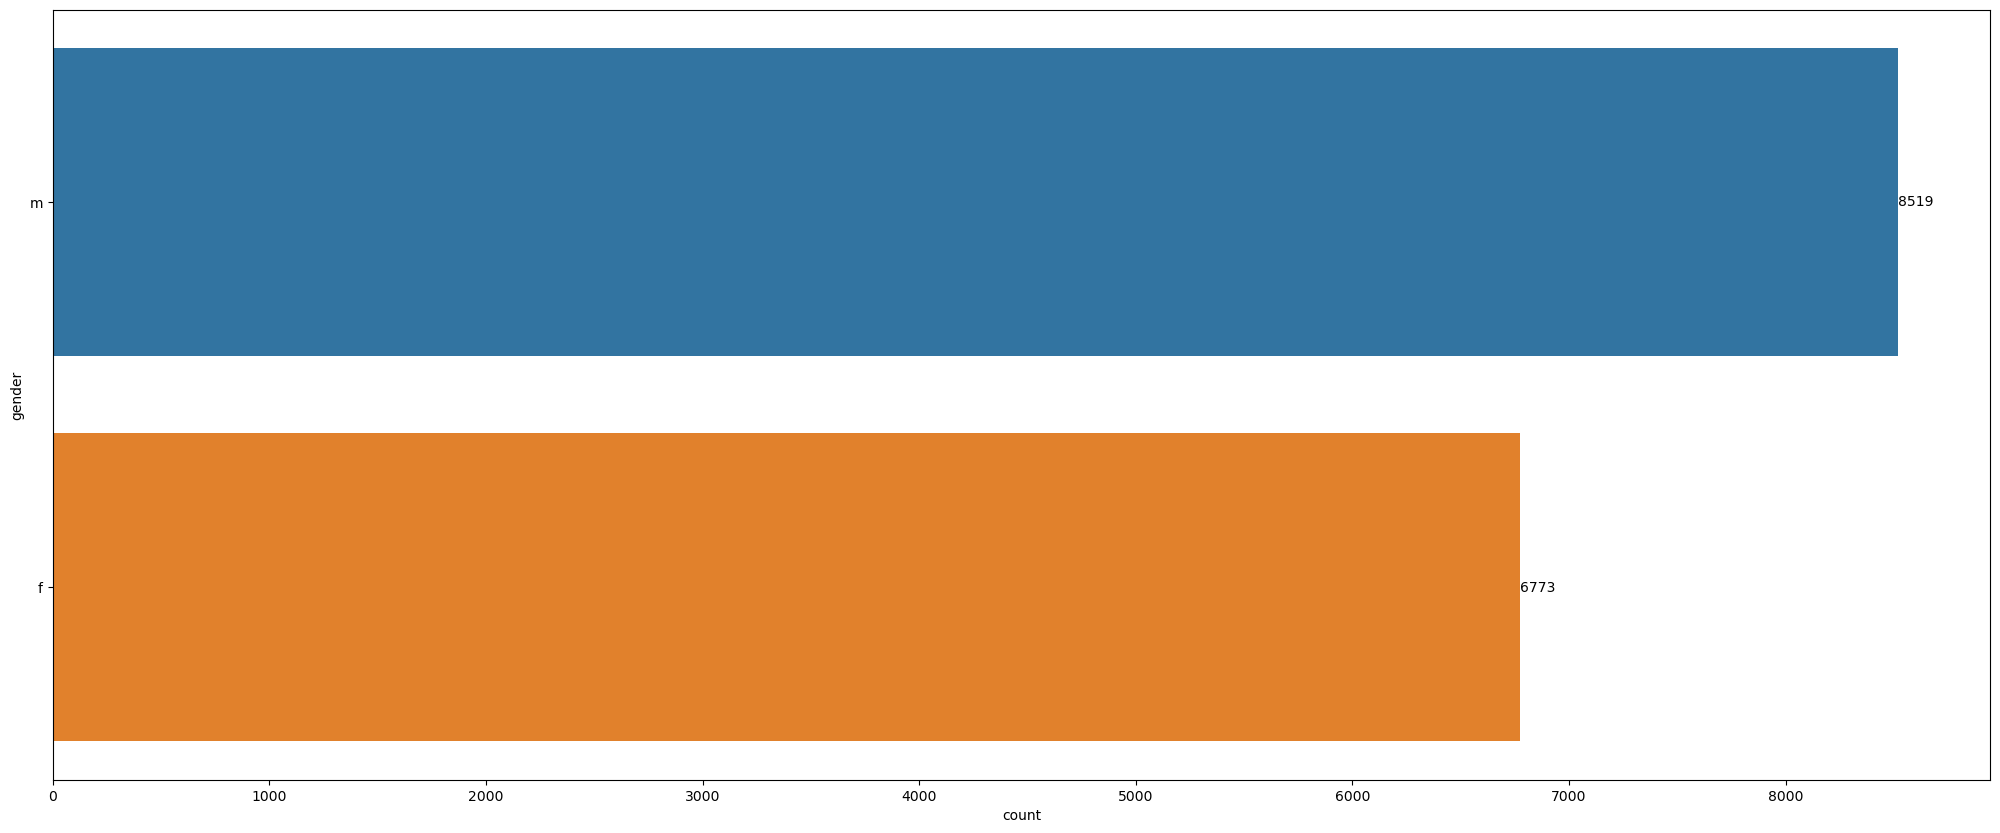

In [6]:
plt.subplots(figsize = (25,10))
ax = sns.countplot(data, y = data['gender'])
ax.bar_label(ax.containers[0])
plt.show()

### 3.2. Processing Columns

In [4]:
stopword_en = pd.read_csv('../../en_stopword_1106.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    text = text.lower()
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def clean(text):
    text = str(text).lower()
    text = re.sub(r'@[a-z0-9_]+', '', text) # Removes Twitter usernames
    text = re.sub('rt|cc', ' ', text)  # remove RT and cc
    text = re.sub('#\S+', '', text)  # remove hashtags
    text = re.sub('@\S+', '  ', text)  # remove mentions
    text = re.sub('\[.*?\]', '', text) # Removes all text enclosed in square brackets 
    text = re.sub('<.*?>+', '', text) # remove html tags
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove URLs
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    # text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuations
    text = re.sub(r'[^\w\s.,]', '', text) # Removes all non-word characters
    # text = [word for word in text.split(' ') if word not in nltk_stopword]
    return text


repl_list = ['s/o','d/o','w/o','/','&',',','-']

def clean_data(name):
	name = str(name).lower()
	name = (''.join(i for i in name if ord(i)<128)).strip()
	for repl in repl_list:
		name = name.replace(repl," ")
	if '@' in name:
		pos = name.find('@')
		name = name[:pos].strip()
	name = name.split(" ")
	name = " ".join([each.strip() for each in name])
	return name

def remove_records(merged_data):
	merged_data['delete'] = 0
	merged_data.loc[merged_data['name'].str.find('with') != -1,'delete'] = 1	
	merged_data.loc[merged_data['count_words']>=5,'delete']=1
	merged_data.loc[merged_data['count_words']==0,'delete']=1
	merged_data.loc[merged_data['name'].str.contains(r'\d') == True,'delete']=1
	cleaned_data = merged_data[merged_data.delete==0]
	return cleaned_data

def stop_word(text):
    return " ".join([word for word in text.split(' ') if word not in nltk_stopword])

lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word, pos='v')

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence) 
    words = [word for word in words if word.isalnum()] 
    words = [lemmatize_word(word) for word in words]  
    return ' '.join(words)  

In [5]:
data['clean_text'] = data['name'] \
                    .progress_apply(clean_data) \
                    # .progress_apply(stop_word) \
                    # .progress_apply(lemmatize_sentence) \
                    # .progress_apply(lower_text) \
                    # .progress_apply(remove_duplicate_words) \
                    # .progress_apply(alphanumeric_text) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (nltk_stopword)])) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if len(word) >= 4])) \
                    # .progress_apply(lemmatizer) \
data.head()

  0%|          | 0/15292 [00:00<?, ?it/s]

,name,gender,race,clean_text
0,barjraj,m,indian,barjraj
1,ramdin verma,m,indian,ramdin verma
2,sharat chandran,m,indian,sharat chandran
3,birender mandal,m,indian,birender mandal
4,amit,m,indian,amit


In [6]:
data['count_words'] = data['clean_text'].str.split().apply(len)
data = remove_records(data)
indian_data = data[['name','count_words']].drop_duplicates(subset='name',keep='first')
indian_data['label'] = 'indian'
indian_data.head()

,name,count_words,label
0,barjraj,1,indian
1,ramdin verma,2,indian
2,sharat chandran,2,indian
3,birender mandal,2,indian
4,amit,1,indian


In [25]:
fake = Faker('en_US')

non_indian_name = []
for i in range(16_000):
    non_indian_name.append(fake.name())

non_indian_data = pd.DataFrame(non_indian_name, columns=['name']).drop_duplicates()
non_indian_data['count_words'] = non_indian_data['name'].str.split().apply(len)
non_indian_data['label'] = 'non-indian'
non_indian_data

,name,count_words,label
0,Mitchell Anderson,2,non-indian
1,Adam Maddox,2,non-indian
2,Adam Gomez,2,non-indian
3,Heather Ramirez,2,non-indian
4,Benjamin Reyes,2,non-indian
...,...,...,...
15995,Mary Rice,2,non-indian
15996,Alexandra Waters,2,non-indian
15997,Caitlin Miller,2,non-indian
15998,Sally Young,2,non-indian


In [29]:
data = pd.concat([indian_data, non_indian_data], axis=0)
data['text_to_letter'] = data['name'].apply(lambda x: ' '.join(list(x)))
data

,name,count_words,label,text_to_letter
0,barjraj,1,indian,b a r j r a j
1,ramdin verma,2,indian,r a m d i n v e r m a
2,sharat chandran,2,indian,s h a r a t c h a n d r a n
3,birender mandal,2,indian,b i r e n d e r m a n d a l
4,amit,1,indian,a m i t
...,...,...,...,...
15995,Mary Rice,2,non-indian,M a r y R i c e
15996,Alexandra Waters,2,non-indian,A l e x a n d r a W a t e r s
15997,Caitlin Miller,2,non-indian,C a i t l i n M i l l e r
15998,Sally Young,2,non-indian,S a l l y Y o u n g


<Axes: xlabel='text_len'>

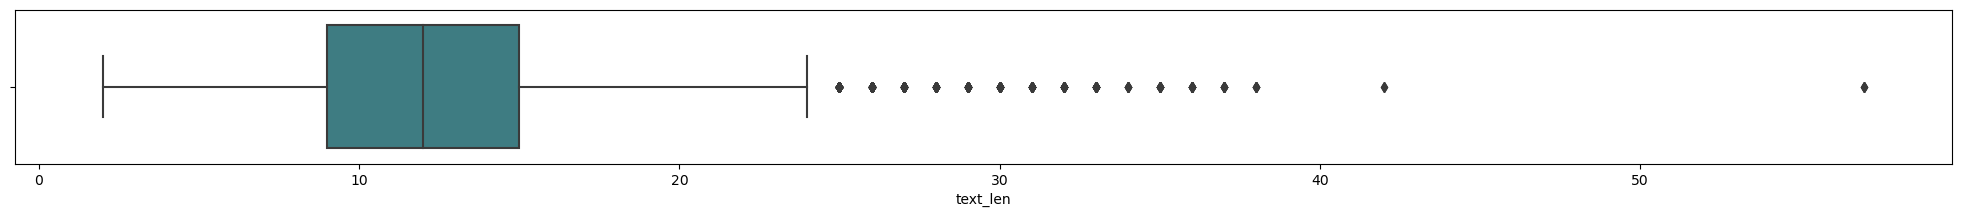

In [30]:
text_len = [len(word) for word in data['text_to_letter'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

In [32]:
print(data['text_len'].quantile(.25))
print(data['text_len'].quantile(1.))

9.0
57.0


<Axes: xlabel='text_len'>

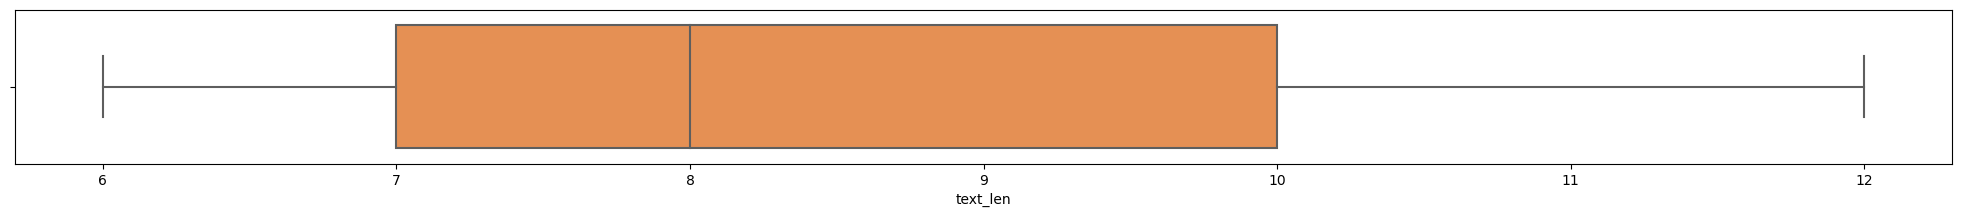

In [16]:
Q1 = data['text_len'].quantile(.25)
Q3 = data['text_len'].quantile(.75)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['text_len'], palette="Oranges")

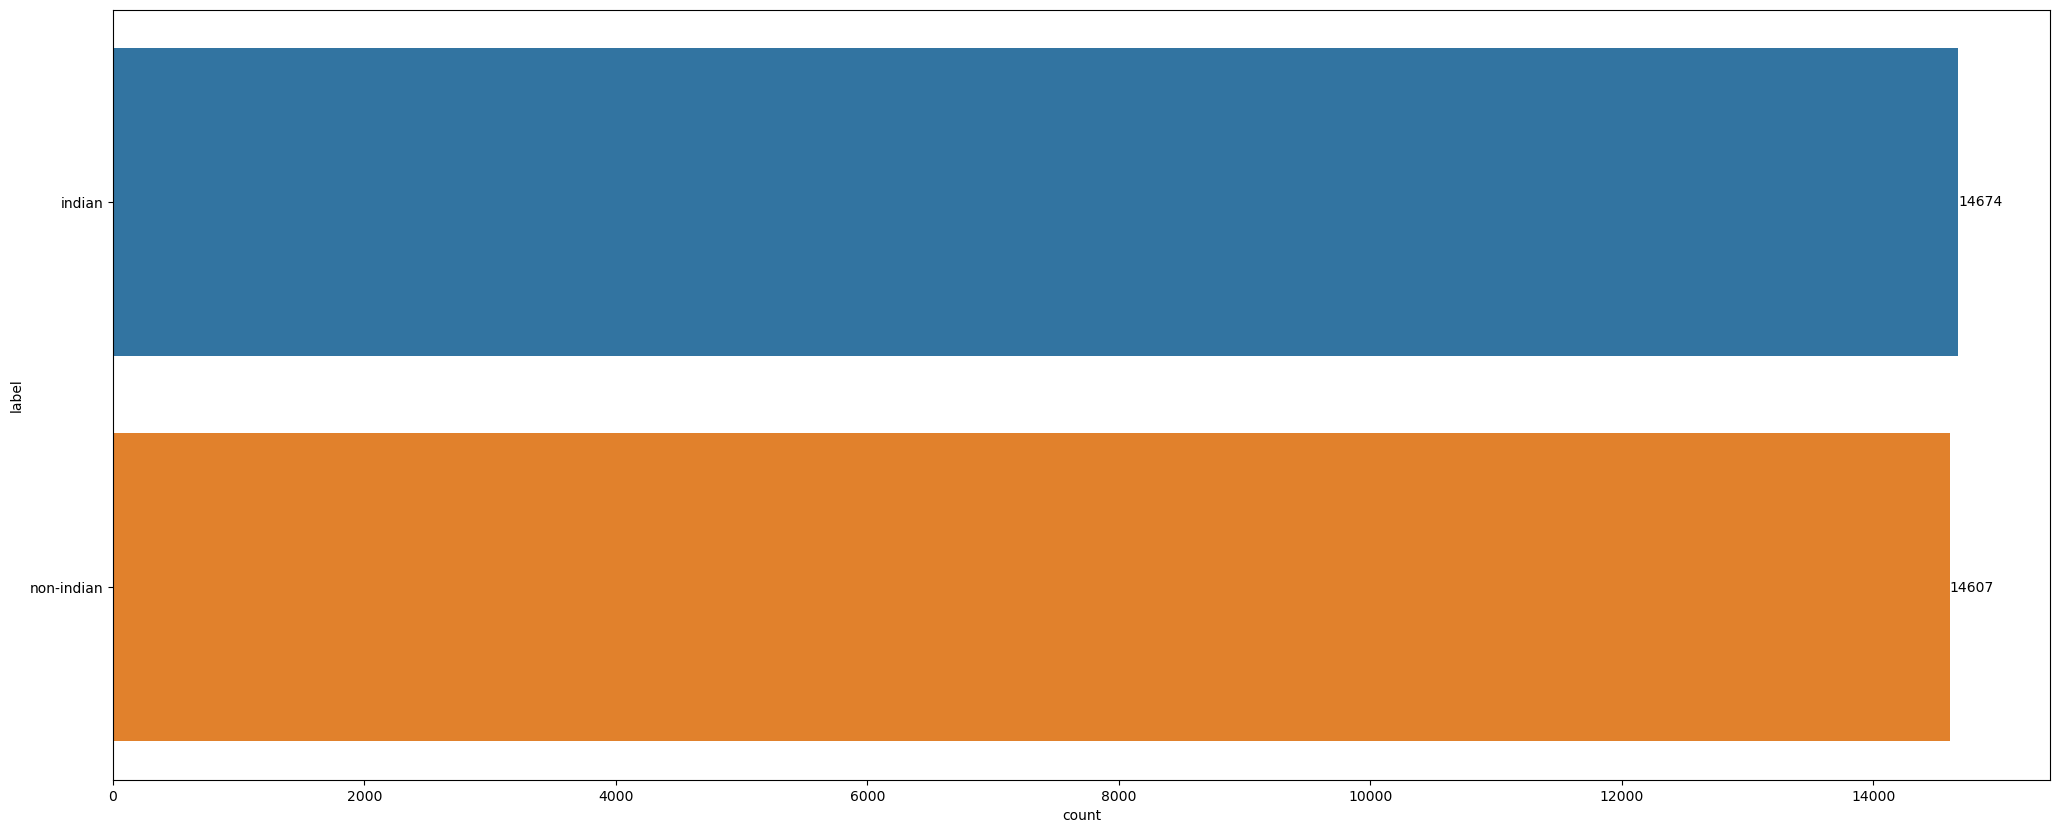

In [33]:
plt.subplots(figsize = (25,10))
ax = sns.countplot(data, y = data['label'])
ax.bar_label(ax.containers[0])
plt.show()

# 4. Preparing Dataset

In [62]:
LE = LabelEncoder()

X = data['text_to_letter']
# Y = LE.fit_transform(data['label']) ### For Classification Algoritms
Y = pd.get_dummies(data['label']) ### For Deep Learning Algoritms
# Y = data['label'] ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(20554,) (20554, 2)
(5798,) (5798, 2)
(2929,) (2929, 2)


In [63]:
vocab_size = 27
embedding_dim = 27
max_length = 60
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
num_label = y_train.shape[1]

In [64]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

27


In [ ]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

print(training_padded.shape)
print(testing_padded.shape)
print(validating_padded.shape)


# 5. Deep Learning Model

In [65]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(num_label, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(num_label, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(num_label, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(32, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(num_label, activation='softmax'))
    return model

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

opt = Adam(learning_rate = 0.000_1)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 27)            729       
                                                                 
 bidirectional_4 (Bidirectio  (None, 60, 128)          35712     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 67,675
Trainable params: 67,675
Non-trainable params: 0
_________________________________________________________________


In [66]:
num_epoch = 10
batch_size = 32
history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/10
643/643 [==============================] - 19s 24ms/step - loss: 0.4631 - accuracy: 0.7813 - val_loss: 0.3207 - val_accuracy: 0.8658
Epoch 2/10
643/643 [==============================] - 14s 22ms/step - loss: 0.3177 - accuracy: 0.8674 - val_loss: 0.2917 - val_accuracy: 0.8764
Epoch 3/10
643/643 [==============================] - 14s 22ms/step - loss: 0.2896 - accuracy: 0.8808 - val_loss: 0.2700 - val_accuracy: 0.8873
Epoch 4/10
643/643 [==============================] - 14s 22ms/step - loss: 0.2743 - accuracy: 0.8868 - val_loss: 0.2656 - val_accuracy: 0.8877
Epoch 5/10
643/643 [==============================] - 15s 23ms/step - loss: 0.2591 - accuracy: 0.8932 - val_loss: 0.2469 - val_accuracy: 0.8993
Epoch 6/10
643/643 [==============================] - 15s 23ms/step - loss: 0.2474 - accuracy: 0.8985 - val_loss: 0.2355 - val_accuracy: 0.9027
Epoch 7/10
643/643 [==============================] - 14s 22ms/step - loss: 0.2363 - accuracy: 0.9032 - val_loss: 0.2179 - val_accuracy:

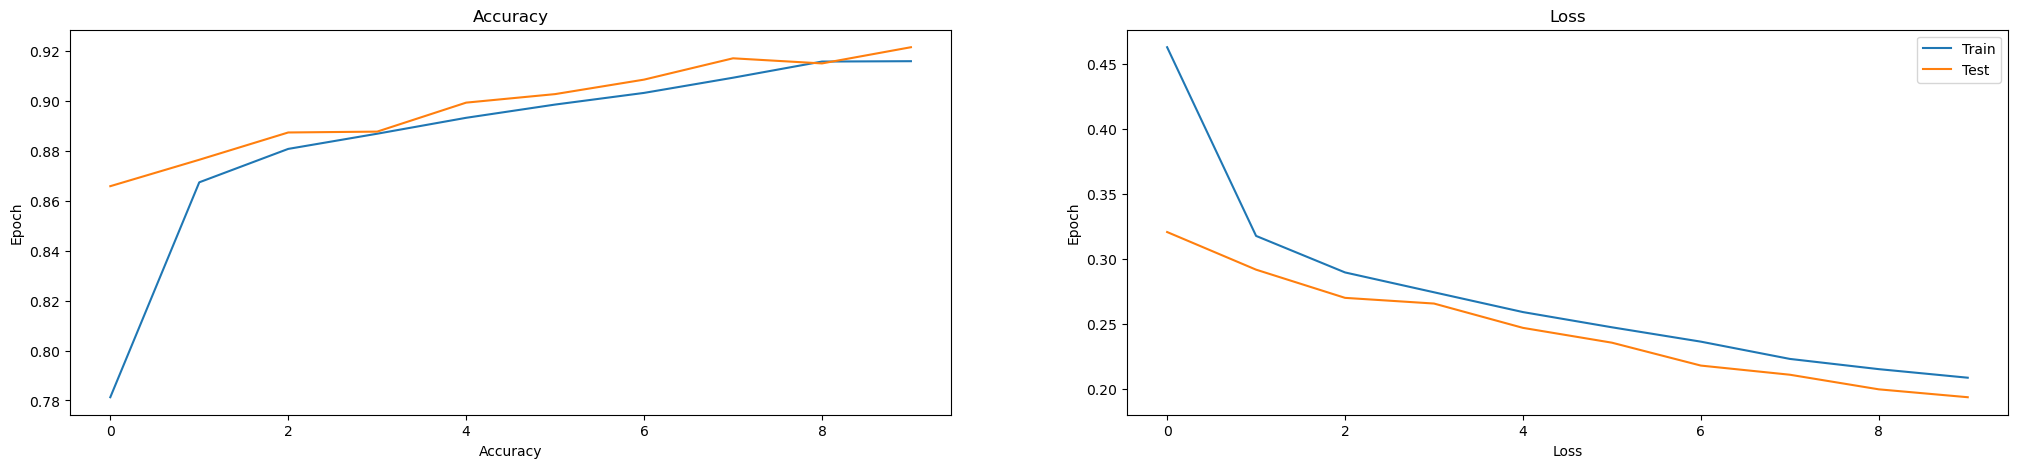

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [68]:
train_predictions = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals  Diff
0                  0        0  True
1                  1        1  True
2                  1        1  True
3                  0        0  True
4                  1        1  True


True     5290
False     508
Name: Diff, dtype: int64

In [69]:
y_pred = model.predict(testing_padded, verbose=0).argmax(axis=1)
print(classification_report(testing_label.argmax(axis=1),y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2902
           1       0.91      0.91      0.91      2896

    accuracy                           0.91      5798
   macro avg       0.91      0.91      0.91      5798
weighted avg       0.91      0.91      0.91      5798



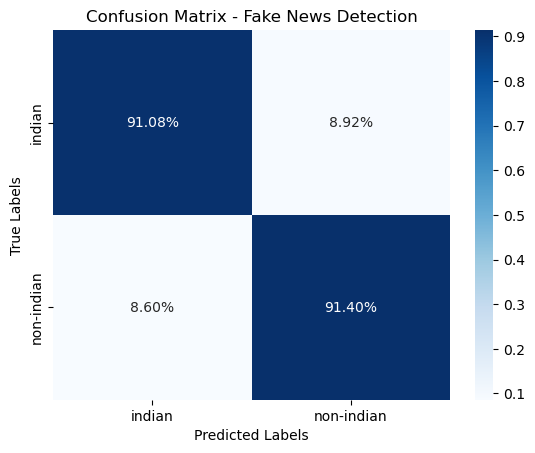

In [70]:
labels = y_train.columns

y_pred = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 6. Classification Algoritms

In [59]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
linear = LinearRegression()
pac = PassiveAggressiveClassifier(random_state=42)

model = StackingClassifier([
    ('XGB', XGB),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('extraTres', extraTrees),
    ('knn', knn),
    ('decisionTree', decisionTree),
    # ('pac', pac),
    # ('linear', linear),
    # ('gradient', gradient),

], n_jobs=-1)

In [60]:
model.fit(training_padded, training_label)

MemoryError: Unable to allocate 516. MiB for an array with shape (4111, 16443) and data type int64

In [42]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))

Train Score        : 100.0 %
Test Score         : 97.91 %


ValueError: could not convert string to float: 'Network Security Engineer'

In [ ]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals   Diff
0                  5        2  False
1                  5        2  False
2                  4        4   True
3                  1        2  False
4                  1        1   True


False    1030
True      452
Name: Diff, dtype: int64

In [ ]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.34      0.43      0.38       179
           1       0.35      0.28      0.32       253
           2       0.19      0.20      0.20       202
           3       0.40      0.39      0.39       222
           4       0.38      0.36      0.37       223
           5       0.22      0.22      0.22       195
           6       0.24      0.25      0.25       208

    accuracy                           0.30      1482
   macro avg       0.30      0.31      0.30      1482
weighted avg       0.31      0.30      0.31      1482



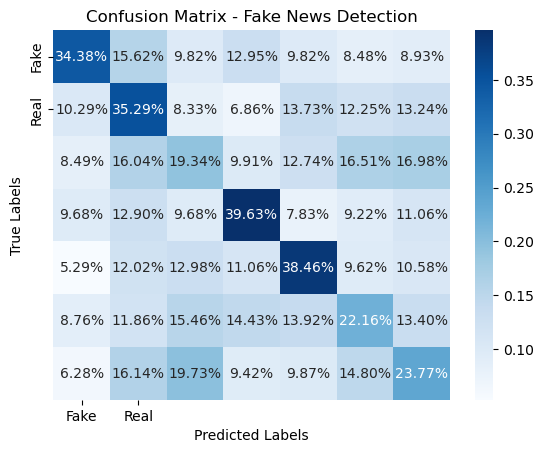

In [29]:
labels = ['Fake','Real']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()